# Imports

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.fft
import torchvision
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [2]:
image_size = 512

In [3]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [4]:
sample = dataset[2390]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [5]:
image.shape, label

(torch.Size([3, 512, 512]), 23)

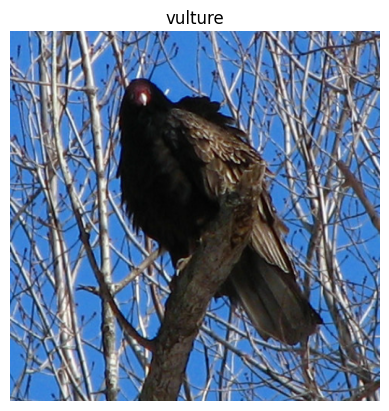

In [6]:
plt.title(f"{dataset.classes_names[image_tag]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# FFT

In [7]:
def compute_fft(image):
    fft_image = torch.fft.fft2(image)
    fft_image_shifted = torch.fft.fftshift(fft_image)
    return fft_image_shifted

In [8]:
def apply_low_pass_filter(fft_image_shifted, filter_size, norm_type='l2'):
    """
    
    :param fft_image_shifted: 
    :param filter_size: 
    :param norm_type: could be l2 or l-infinity
    :return: 
    """
    height, width = fft_image_shifted.shape[1], fft_image_shifted.shape[2]
    y, x = torch.meshgrid(torch.arange(0, height), torch.arange(0, width))

    center_y, center_x = height // 2, width // 2
    distance_x = torch.abs(x - center_x)
    distance_y = torch.abs(y - center_y)

    if norm_type == 'l2':
        distance = torch.sqrt(distance_x**2 + distance_y**2)
        low_pass_mask = distance <= filter_size
    elif norm_type == 'l-infinity':
        low_pass_mask = (distance_x <= filter_size) & (distance_y <= filter_size)
    else:
        raise ValueError("Invalid norm type. Choose 'l2' or 'l-infinity'.")

    low_pass_mask = low_pass_mask.to(torch.complex64)
    fft_filtered = fft_image_shifted * low_pass_mask
    return fft_filtered

In [9]:
def crop_fft_filtered(fft_filtered, filter_size):
    """
    Crops the fft_filtered tensor so that only the central region remains.

    This function assumes that the filter was applied with a given filter_size so that
    the nonzero elements of fft_filtered are contained in a central square of size
    (2 * filter_size) x (2 * filter_size).

    Args:
      fft_filtered (torch.Tensor): The FFT result after applying the low-pass filter, shape [C, H, W].
      filter_size (int): The parameter used in the filtering, defining half the side length of the cropping square.
    
    Returns:
      torch.Tensor: The cropped FFT tensor with shape [C, 2 * filter_size, 2 * filter_size].
    """
    # Get the dimensions
    _, H, W = fft_filtered.shape
    center_y, center_x = H // 2, W // 2

    # Crop a central square: from center - filter_size to center + filter_size.
    cropped_fft = fft_filtered[:, center_y - filter_size:center_y + filter_size,
                                     center_x - filter_size:center_x + filter_size]
    return cropped_fft

In [10]:
def restore_image_from_fft(fft_filtered):
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_filtered) 
    reconstructed_image = torch.fft.ifft2(fft_filtered_shifted_back)
    return torch.abs(reconstructed_image)

In [11]:
def compute_power_spectrum(fft_tensor):
    """
    Calculates the power spectrum of an FFT tensor.

    The power spectrum is defined as the squared magnitude of the FFT coefficients.
    The result is returned as a float32 tensor.

    Args:
      fft_tensor (torch.Tensor): A complex FFT tensor.
    
    Returns:
      torch.Tensor: The power spectrum as a float32 tensor.
    """
    power_spec = (torch.abs(fft_tensor) ** 2).float()
    return power_spec

In [12]:
fft_image_shifted = compute_fft(image)

filter_size = 96  # Size of the low-pass filter
filtered_fft = apply_low_pass_filter(fft_image_shifted, filter_size, norm_type='l-infinity')

F:\research\Sigma-Image-Tokenizer\venv\lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
filtered_fft

tensor([[[-0.+0.j, -0.+0.j, -0.+0.j,  ..., -0.+0.j, 0.-0.j, 0.-0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., -0.+0.j, 0.-0.j, -0.+0.j],
         [0.+0.j, 0.-0.j, 0.-0.j,  ..., 0.+0.j, -0.+0.j, 0.-0.j],
         ...,
         [0.+0.j, 0.-0.j, 0.-0.j,  ..., 0.+0.j, -0.+0.j, 0.+0.j],
         [0.+0.j, -0.+0.j, 0.-0.j,  ..., 0.+0.j, -0.+0.j, -0.+0.j],
         [0.+0.j, 0.-0.j, -0.+0.j,  ..., -0.+0.j, 0.+0.j, 0.+0.j]],

        [[-0.+0.j, 0.-0.j, 0.+0.j,  ..., -0.+0.j, 0.+0.j, -0.+0.j],
         [0.+0.j, 0.+0.j, 0.-0.j,  ..., 0.+0.j, 0.-0.j, 0.+0.j],
         [0.+0.j, 0.-0.j, -0.+0.j,  ..., 0.+0.j, -0.+0.j, 0.+0.j],
         ...,
         [-0.+0.j, 0.-0.j, 0.-0.j,  ..., -0.+0.j, 0.+0.j, -0.+0.j],
         [0.+0.j, 0.+0.j, 0.-0.j,  ..., -0.+0.j, 0.-0.j, -0.+0.j],
         [0.+0.j, 0.+0.j, -0.+0.j,  ..., -0.+0.j, -0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.-0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, -0.+0.j],
         [0.+0.j, -0.+0.j, 0.+0.j,  ..., -0.+0.j, 0.-0.j, 0.+0.j],
         [0.+0.j, 0.-0.j, 0.-

In [14]:
croped_filtered_fft = crop_fft_filtered(filtered_fft, filter_size)
croped_filtered_fft.shape

torch.Size([3, 192, 192])

In [15]:
reconstructed_image = restore_image_from_fft(filtered_fft)

In [16]:
reconstructed_image.shape

torch.Size([3, 512, 512])

## Visualise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4902521e-06..1.0740254].


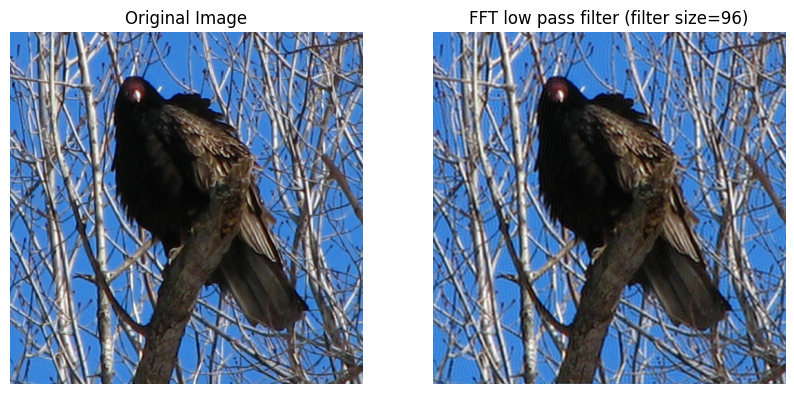

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)
axes[1].set_title(f"FFT low pass filter (filter size={filter_size})")
axes[1].axis("off")

plt.show()

# Tokenizer

In [18]:
from src.tokenizers.fft_tokenizer import FFTTokenizer

In [19]:
tokenizer = FFTTokenizer(
    image_size=image_size,
    num_channels=3,
    num_bins=16,
    embedding_dim=768,
    filter_size=96
) 

In [20]:
batch_size = 16

In [21]:
image_batch = torch.stack([image] * batch_size)
image_batch.shape

torch.Size([16, 3, 512, 512])

In [22]:
embeddings = tokenizer(image_batch)
embeddings.shape

torch.Size([16, 17, 768])

In [55]:
embeddings

tensor([[[  0.5637,   0.3947,   0.6723,  ...,  -1.5964,  -2.1859,  -0.7761],
         [  0.8964,   0.6057,   0.8816,  ...,   1.0458,   0.0450,   0.9783],
         [  0.9642,  -0.3507,   0.9812,  ...,   1.0458,   0.0451,   0.9783],
         ...,
         [-20.7423, -16.8985,   1.2387,  ...,  -7.4267,   6.4673,  -6.4509],
         [ -0.9434,   0.1229,   1.0352,  ...,   1.0457,   0.0596,   0.9782],
         [ -0.4361,   0.9366,   0.7596,  ...,   1.0457,   0.0597,   0.9782]],

        [[  0.5637,   0.3947,   0.6723,  ...,  -1.5964,  -2.1859,  -0.7761],
         [  0.8964,   0.6057,   0.8816,  ...,   1.0458,   0.0450,   0.9783],
         [  0.9642,  -0.3507,   0.9812,  ...,   1.0458,   0.0451,   0.9783],
         ...,
         [-20.7423, -16.8985,   1.2387,  ...,  -7.4267,   6.4673,  -6.4509],
         [ -0.9434,   0.1229,   1.0352,  ...,   1.0457,   0.0596,   0.9782],
         [ -0.4361,   0.9366,   0.7596,  ...,   1.0457,   0.0597,   0.9782]],

        [[  0.5637,   0.3947,   0.6723,  ...

# Check random transforms

In [56]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [57]:
sample = dataset[2390]
image_base = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [58]:
random_transform = transforms.Compose([
        transforms.Resize((
            int(image_size * 1.25),
            int(image_size * 1.25)
        )),
        transforms.RandomCrop(image_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225]
        # ),
])

dataset_aug = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=random_transform
)

In [59]:
sample_aug = dataset_aug[2390]
image_aug = sample_aug["image"]
label_aug = sample_aug["label_encoded"]
image_tag_aug = sample_aug["tag"]

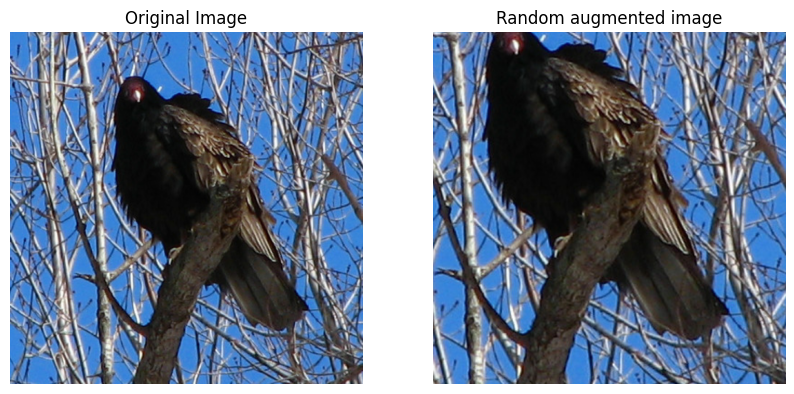

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_base.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_base.shape[0] == 1 else None)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image_aug.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image_aug.shape[0] == 1 else None)
axes[1].set_title(f"Random augmented image")
axes[1].axis("off")

plt.show()

In [61]:
embeddings_base = tokenizer(image_base.unsqueeze(dim=0))
embeddings_aug = tokenizer(image_aug.unsqueeze(dim=0))

In [62]:
cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

In [63]:
similarity = cos_sim(embeddings_base, embeddings_aug)
similarity.shape

torch.Size([1, 768])

In [64]:
similarity.abs().sum() / similarity.shape[1]

tensor(0.9072, grad_fn=<DivBackward0>)